学习R语言KNN算法。

# 导入数据

In [1]:
rm(list = ls())

load(file = "data/pimadiabetes.rdata")

dim(pimadiabetes)

[1] 768   9

In [2]:
str(pimadiabetes)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 ...
 $ triceps : num  35 29 22.3 23 35 ...
 $ insulin : num  190.5 60.8 229.9 94 168 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "pos","neg": 2 1 2 1 2 1 2 1 2 2 ...


# 数据准备

KNN依赖于距离计算，凡是涉及距离计算的算法都应该采用标准化。

In [ ]:
pimadiabetes[, -9] <- scale(pimadiabetes[, -9])
str(pimadiabetes)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  0.64 -0.844 1.233 -0.844 -1.141 ...
 $ glucose : num  0.864 -1.203 2.012 -1.071 0.503 ...
 $ pressure: num  -0.0294 -0.5223 -0.6866 -0.5223 -2.6582 ...
 $ triceps : num  0.63538 0.00309 -0.69876 -0.62921 0.63538 ...
 $ insulin : num  0.351 -0.976 0.756 -0.636 0.121 ...
 $ mass    : num  0.172 -0.844 -1.323 -0.626 1.551 ...
 $ pedigree: num  0.468 -0.365 0.604 -0.92 5.481 ...
 $ age     : num  1.4251 -0.1905 -0.1055 -1.0409 -0.0205 ...
 $ diabetes: Factor w/ 2 levels "pos","neg": 2 1 2 1 2 1 2 1 2 2 ...


# class包

In [ ]:
# 划分是随机的，设置种子数可以让结果复现
set.seed(123)
ind <- sample(1:nrow(pimadiabetes), size = 0.7*nrow(pimadiabetes))

# 去掉真实结果列
train <- pimadiabetes[ind, -9]
test <- pimadiabetes[-ind, -9]

dim(train)

[1] 537   8

In [5]:
dim(test)

[1] 231   8

In [ ]:
# 把真实结果列单独拿出来，后面用
truth_train <- pimadiabetes[ind, 9]
truth_test <- pimadiabetes[-ind, 9]

## 建立模型

In [7]:
library(class)

In [8]:
f <- knn(
  train = train,
  test = test,
  cl = truth_train,
  k = 8,
  prob = TRUE # 需要计算概率
)

In [9]:
head(f)

[1] neg neg pos neg neg pos
Levels: pos neg

In [ ]:
# 查看测试集的预测概率，只看前6个
prob <- attr(f, "prob")
head(prob)

[1] 0.500 0.750 1.000 0.750 0.500 0.625

In [ ]:
prob <- ifelse(f == "pos", prob, 1 - prob)
head(prob)
## [1] 0.500 0.250 1.000 0.250 0.375 0.625

[1] 0.500 0.250 1.000 0.250 0.500 0.625

## 模型评价

In [ ]:
# 借助caret包，f是预测的类别，truth_test是真实的结果
caret::confusionMatrix(f, truth_test)

Confusion Matrix and Statistics

          Reference
Prediction pos neg
       pos 131  29
       neg  19  52
                                          
               Accuracy : 0.7922          
                 95% CI : (0.7341, 0.8426)
    No Information Rate : 0.6494          
    P-Value [Acc > NIR] : 1.554e-06       
                                          
                  Kappa : 0.5304          
                                          
 Mcnemar's Test P-Value : 0.1939          
                                          
            Sensitivity : 0.8733          
            Specificity : 0.6420          
         Pos Pred Value : 0.8187          
         Neg Pred Value : 0.7324          
             Prevalence : 0.6494          
         Detection Rate : 0.5671          
   Detection Prevalence : 0.6926          
      Balanced Accuracy : 0.7577          
                                          
       'Positive' Class : pos             
                              

In [ ]:
caret::precision(f, truth_test) # 精准率

[1] 0.81875

In [ ]:
caret::recall(f, truth_test) # 召回率，灵敏度

[1] 0.8733333

In [ ]:
caret::F_meas(f, truth_test) # F1分数

[1] 0.8451613

[1] 0.8488

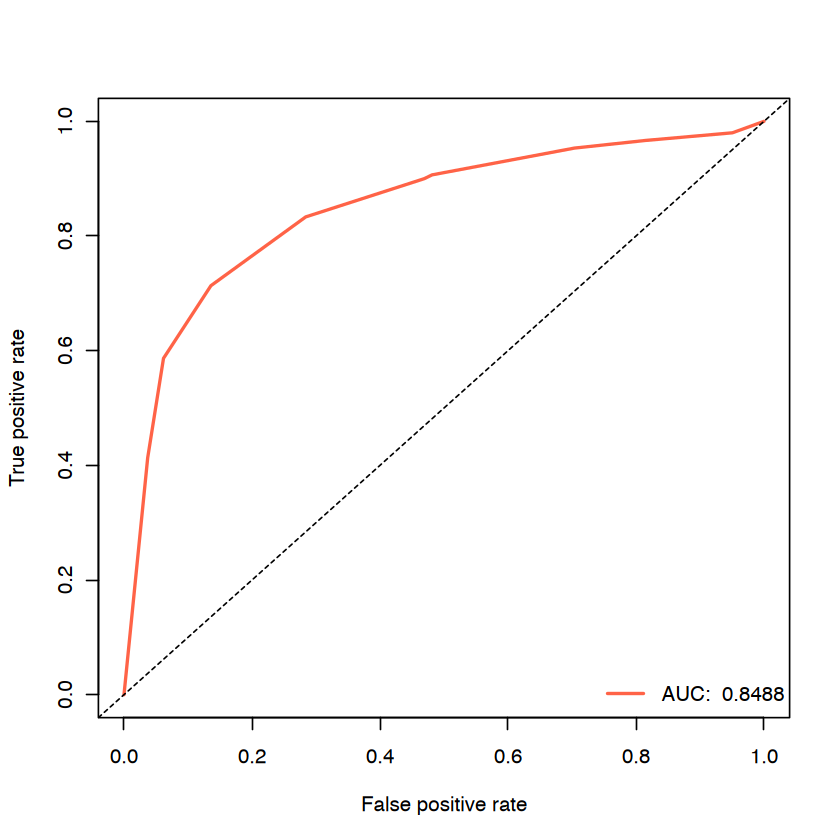

In [ ]:
library(ROCR)

# ROCR画ROC曲线就是2步，先prediction，再performance
pred <- prediction(prob, truth_test) # 预测概率，真实类别
perf <- performance(pred, "tpr", "fpr") # ROC曲线的横纵坐标，不要写错了
auc <- round(performance(pred, "auc")@y.values[[1]], digits = 4) # 提取AUC值
auc
## [1] 0.8477

# 画图
plot(perf, lwd = 2, col = "tomato")
abline(0, 1, lty = 2) # 添加对角线
# 添加图例
legend(
  "bottomright",
  legend = paste("AUC: ", auc),
  col = "tomato",
  lwd = 2,
  bty = "n"
)

Setting levels: control = pos, case = neg

Setting direction: controls > cases




Call:
roc.default(response = truth_test, predictor = prob)

Data: prob in 150 controls (truth_test pos) > 81 cases (truth_test neg).
Area under the curve: 0.8488


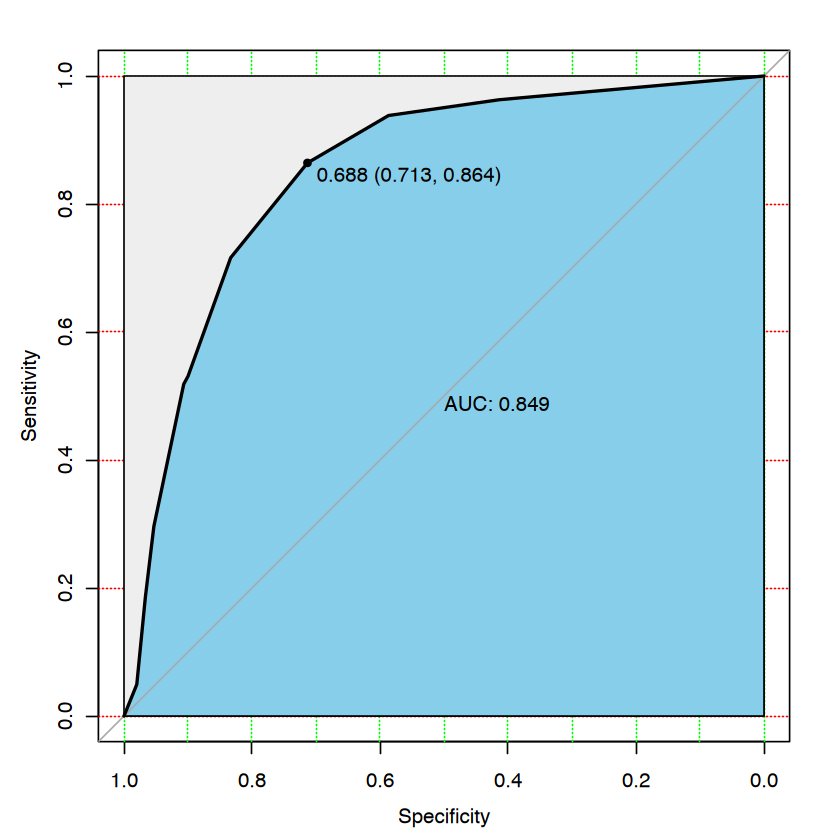

In [19]:
library(pROC)

rocc <- roc(truth_test, prob) # 预测概率，真实结果
print(rocc) # 看下结果

# 画图
plot(
  rocc,
  print.auc = TRUE,
  auc.polygon = TRUE,
  max.auc.polygon = TRUE,
  auc.polygon.col = "skyblue",
  grid = c(0.1, 0.2),
  grid.col = c("green", "red"),
  print.thres = TRUE
)


[1] 0.8488

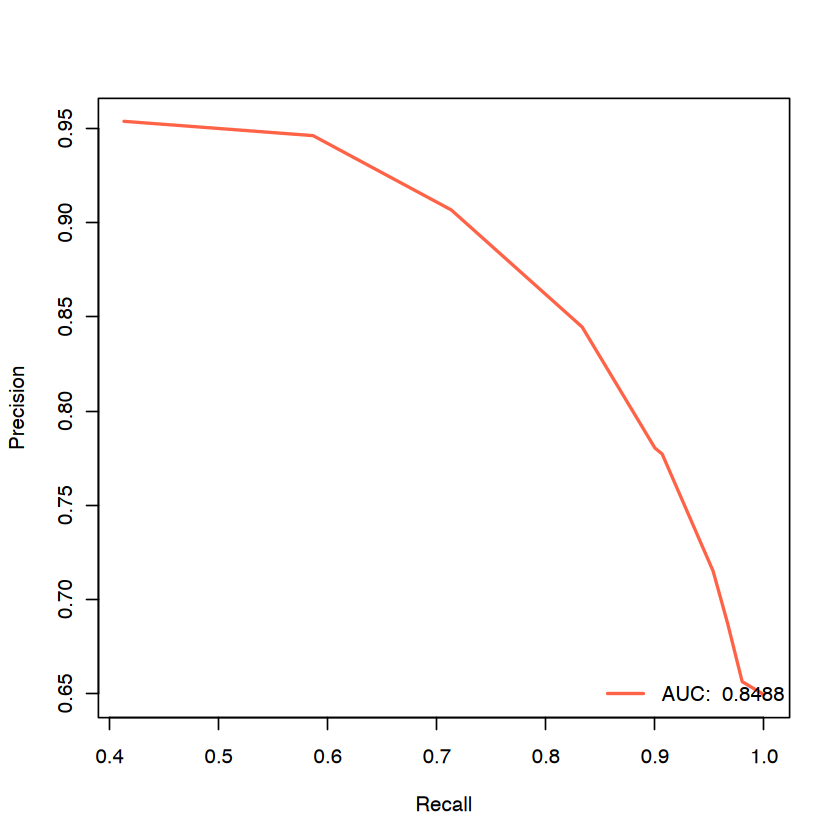

In [ ]:
library(ROCR)

# ROCR画ROC曲线就是2步，先prediction，再performance
pred <- prediction(prob, truth_test) # 预测概率，真实类别
perf <- performance(pred, "prec", "rec") # 对于PR曲线，precision在y轴，recall在x轴
auc <- round(performance(pred, "auc")@y.values[[1]], digits = 4) # 提取AUC值
auc
## [1] 0.8477

# 画图
plot(perf, lwd = 2, col = "tomato")
# 添加图例
legend(
  "bottomright",
  legend = paste("AUC: ", auc),
  col = "tomato",
  lwd = 2,
  bty = "n"
)

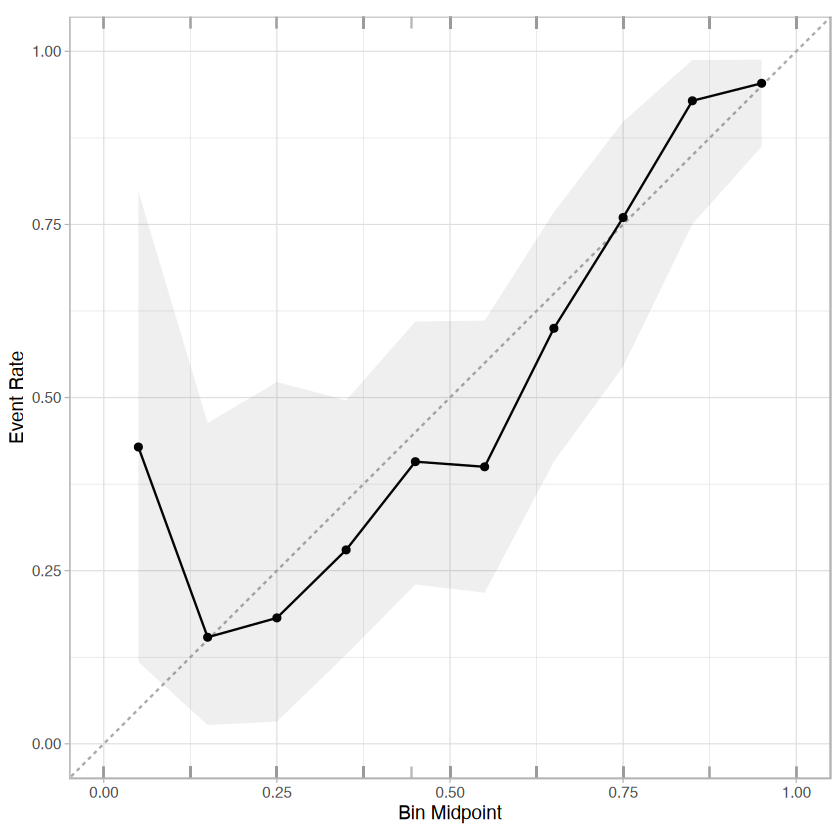

In [23]:
library(probably)

cali_data <- data.frame(.pred_pos = prob, diabetes = truth_test)

cal_plot_breaks(cali_data, diabetes, .pred_pos, conf_level = 0.95)

## 超参数调优

In [ ]:
aucs <- vector("list", 50)
for (i in 1:50) { # K的值选择1~50
  f <- knn(
    train = train,        # 训练集
    test = test,          # 测试集
    cl = truth_train,     # 训练集的真实类别
    k = i,                # 使用的近邻个数
    prob = TRUE           # 需要计算概率
  )
  prob <- attr(f, "prob")
  prob <- ifelse(f == "pos", prob, 1 - prob)
  pred <- prediction(prob, truth_test)
  perf <- performance(pred, "tpr", "fpr")
  auc <- round(performance(pred, "auc")@y.values[[1]], digits = 4)
  aucs[[i]] <- auc
}
aucs <- do.call(rbind, aucs)[, 1]
aucs # 50个AUC值，分别对应50个K值

[1] 0.6911 0.7958 0.8300 0.8470 0.8449 0.8514 0.8495 0.8488 0.8519 0.8530
[11] 0.8533 0.8480 0.8538 0.8501 0.8484 0.8465 0.8508 0.8511 0.8518 0.8488
[21] 0.8505 0.8463 0.8481 0.8497 0.8495 0.8467 0.8476 0.8451 0.8498 0.8489
[31] 0.8446 0.8458 0.8440 0.8451 0.8428 0.8398 0.8437 0.8429 0.8439 0.8442
[41] 0.8434 0.8449 0.8434 0.8433 0.8412 0.8400 0.8406 0.8399 0.8402 0.8384

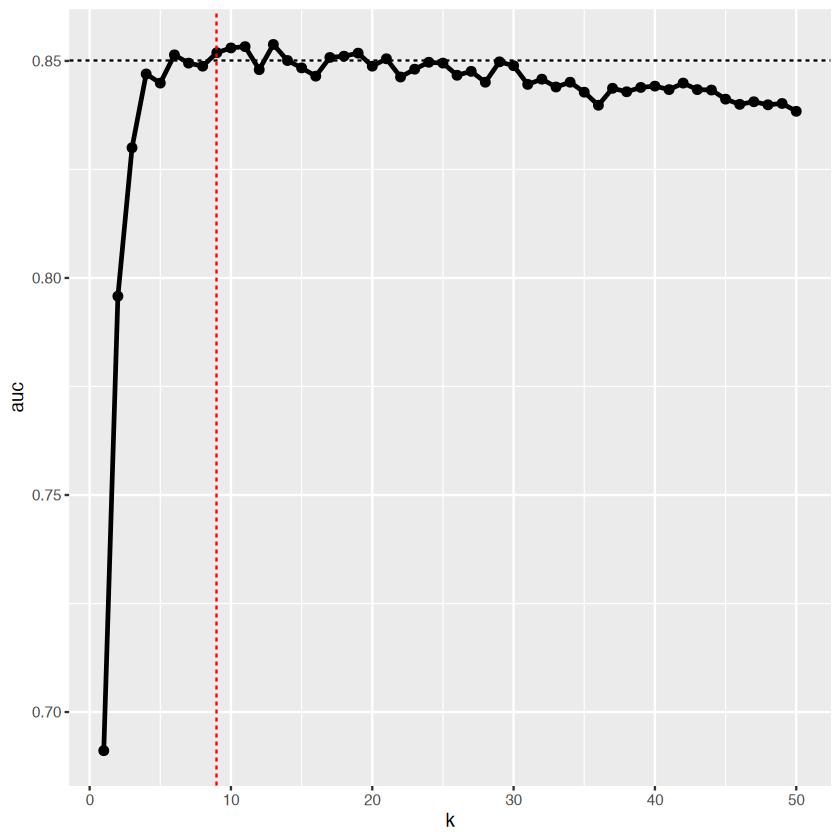

In [29]:
plot_df <- data.frame(k = 1:50, auc = aucs)
library(ggplot2)

ggplot(plot_df, aes(x = k, y = auc)) +
  geom_line(linewidth = 1) +
  geom_point(size = 2) +
  geom_hline(yintercept = 0.85, linetype = 2) +
  geom_vline(xintercept = 9, linetype = 2, color = "red")

In [30]:
final_f <- knn(
  train = train,         # 训练集，只有预测变量，没有结果变量
  test = test,           # 测试集，没有结果变量
  cl = truth_train,      # 训练集的真实结果
  k = 9,                 # 这里的K值选择9哦！！！
  prob = TRUE            # 需要计算概率
)

# kknn包

In [32]:
# 划分是随机的，设置种子数可以让结果复现
set.seed(123)
ind <- sample(seq_len(nrow(pimadiabetes)), size = 0.7 * nrow(pimadiabetes))

# 训练集、测试集
train <- pimadiabetes[ind, ]
test  <- pimadiabetes[-ind, ]

# 把真实结果列单独拿出来，后面用
truth_train <- train[, 9]
truth_test  <- test[, 9]

In [33]:
head(train)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
415,-1.1411079,0.5358613,-1.0152001,0.63537979,0.1112031,0.3174506,0.18749875,-1.0408711,neg
463,1.2330766,-1.5634719,-0.1937006,1.16229052,-1.0967887,0.4190457,0.70360271,0.4897110,pos
179,0.3427574,0.6998717,0.4634989,0.93677273,0.8319032,1.8268642,-0.85074547,1.1699697,pos
526,-0.2507887,-1.1370449,-1.0152001,-1.15611670,-0.8358420,-1.5402893,-0.08413491,-1.0408711,pos
195,1.2330766,-1.2026490,-1.4259498,-0.94535241,-0.6734797,-1.1629359,-1.01372567,0.7448080,pos
118,0.3427574,-1.4322636,-2.0009994,0.02521716,-0.8570330,0.1868282,0.54967697,-0.7007418,pos


## 建立模型

In [35]:
library(kknn)
fit <- kknn::kknn(
  diabetes ~ ., train, test,
  scale = FALSE # 数据已标准化，无需再次标准化
)

summary(fit)

ERROR: Error in library(kknn): there is no package called 'kknn'
